In [1]:
# changing core directory
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path:
    sys.path.append(dir1)
os.chdir('../../..')

In [2]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["KAGGLE_USERNAME"] = "recsysaccelerate"
os.environ["KAGGLE_KEY"] = "6363e91b656fea576c39e4f55dcc1d00"

In [3]:
from replay.preprocessing.filters import MinCountFilter, NumInteractionsFilter
from replay.splitters import TimeSplitter
from replay.data import (
    FeatureHint,
    FeatureInfo,
    FeatureSchema,
    FeatureSource,
    FeatureType,
    Dataset,
)
from replay.data.nn import (
    SequenceTokenizer,
    SequentialDataset,
    TensorFeatureSource,
    TensorSchema,
    TensorFeatureInfo
)

import pandas as pd

/opt/miniconda3/envs/replay_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42

np.random.seed(SEED)
random.seed(SEED)

## Prepare data

In [5]:
interactions = pd.read_parquet("/RePlay-Accelerated/replay_benchmarks/data/yelp/interactions.parquet")

In [6]:
interactions

,user_id,item_id,rating,timestamp
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,1531001351000000000
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1325604498000000000
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,1391632230000000000
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1420329663000000000
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1484427255000000000
...,...,...,...,...
6990275,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1418852720000000000
6990276,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,1617209710000000000
6990277,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1577678190000000000
6990278,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1642618767000000000


In [7]:
interactions['rating'].describe()

count    6.990280e+06
mean     3.748584e+00
std      1.478705e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [8]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 1987929
Number of unique items: 150346


In [9]:
pd.to_datetime(interactions['timestamp'], unit='ns').describe()

count                          6990280
mean     2017-01-11 11:22:33.441780992
min                2005-02-16 03:23:22
25%      2015-01-25 04:53:50.249999872
50%                2017-06-03 01:26:07
75%      2019-05-23 00:02:46.249999872
max                2022-01-19 19:48:45
Name: timestamp, dtype: object

In [10]:
pd.to_datetime(interactions['timestamp'], unit='ns')

0         2018-07-07 22:09:11
1         2012-01-03 15:28:18
2         2014-02-05 20:30:30
3         2015-01-04 00:01:03
4         2017-01-14 20:54:15
                  ...        
6990275   2014-12-17 21:45:20
6990276   2021-03-31 16:55:10
6990277   2019-12-30 03:56:30
6990278   2022-01-19 18:59:27
6990279   2018-01-02 22:50:47
Name: timestamp, Length: 6990280, dtype: datetime64[ns]

In [11]:
interactions.head()

,user_id,item_id,rating,timestamp
0,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,1531001351000000000
1,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1325604498000000000
2,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,1391632230000000000
3,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1420329663000000000
4,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1484427255000000000


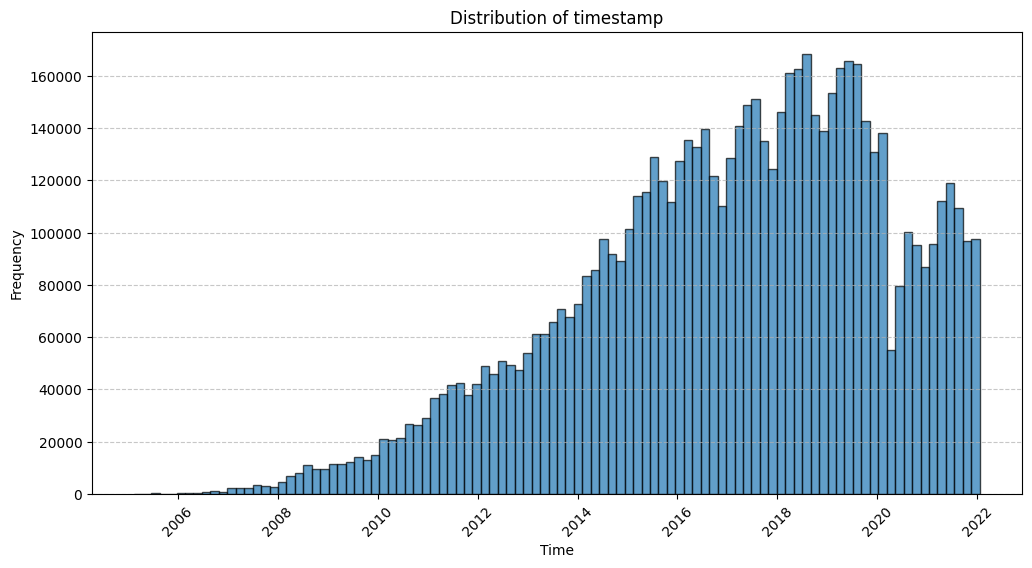

In [12]:
def plot_timestamp_distribution(df: pd.DataFrame, timestamp_col: str = 'timestamp', unit: str = 'ns', bins: int = 100):
    df = df.copy()
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit=unit)
    df = df.sort_values(timestamp_col)
    
    plt.figure(figsize=(12, 6))
    plt.hist(df[timestamp_col], bins=bins, edgecolor='black', alpha=0.7)
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of {timestamp_col}')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

plot_timestamp_distribution(interactions)


In [13]:
# Фильтруем данные по минимальному рейтингу
interactions = interactions[
                interactions['rating']
                > 3
            ]

In [14]:
def filter_data(interactions: pd.DataFrame):
    """Filters raw data based on minimum interaction counts."""

    def log_min_counts(data: pd.DataFrame, message_prefix: str):
        user_min = data.groupby("user_id").size().min()
        item_min = data.groupby("item_id").size().min()
        print(
            f"{message_prefix} - Min itens per user: {user_min}, Min users per item: {item_min}"
        )

    log_min_counts(interactions, "Before filtering")

    interactions = MinCountFilter(
        num_entries=5,
        groupby_column="item_id",
    ).transform(interactions)

    interactions = MinCountFilter(
        num_entries=3,
        groupby_column="user_id",
    ).transform(interactions)

    log_min_counts(interactions, "After filtering")

    return interactions

interactions = filter_data(interactions)

Before filtering - Min itens per user: 1, Min users per item: 1
After filtering - Min itens per user: 3, Min users per item: 1


In [15]:
print(interactions.shape)
print(pd.to_datetime(interactions.timestamp.min(), unit='ns'))
print(pd.to_datetime(interactions.timestamp.max(), unit='ns'))
density = (len(interactions) / (interactions['user_id'].nunique() * interactions['item_id'].nunique())) * 100
print(f"Interaction Density: {density:.2f}%")
mean_seq_len = interactions.groupby('user_id').size().mean()
print(f"Mean Sequence Length: {mean_seq_len:.2f}")

(3277950, 4)
2005-02-16 03:23:22
2022-01-19 19:48:45
Interaction Density: 0.01%
Mean Sequence Length: 9.00


In [16]:
print(f"Number of unique users: {interactions.user_id.nunique()}")
print(f"Number of unique items: {interactions.item_id.nunique()}")

Number of unique users: 364175
Number of unique items: 114493


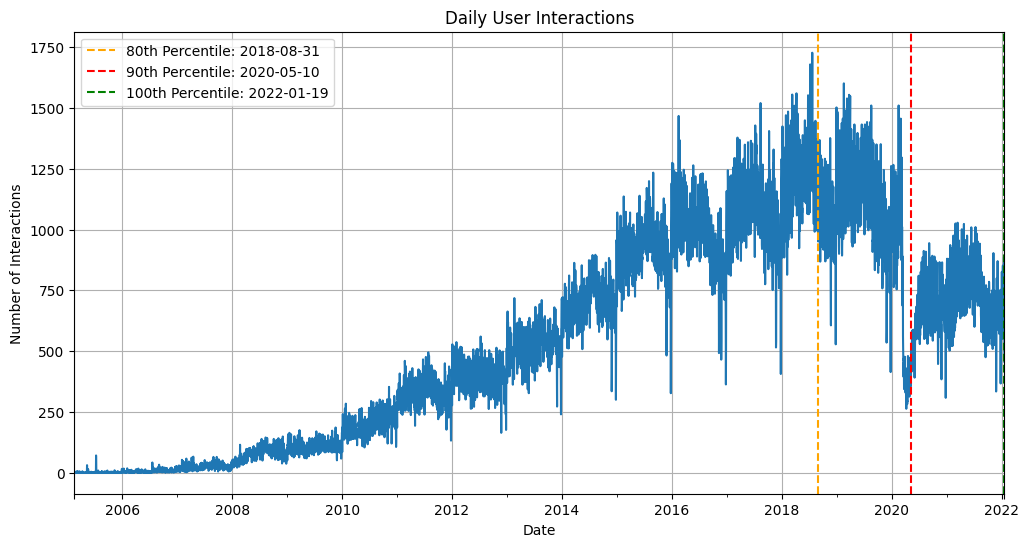

In [17]:
temp_interactions = interactions.copy()
temp_interactions['timestamp'] = pd.to_datetime(temp_interactions['timestamp'], unit='ns')
daily_interactions = temp_interactions.resample('D', on='timestamp').size()
percentile_80_date = daily_interactions.index[int(0.8 * len(daily_interactions)) - 1]
percentile_90_date = daily_interactions.index[int(0.9 * len(daily_interactions)) - 1]
percentile_100_date = daily_interactions.index[int(1 * len(daily_interactions)) - 1]
plt.figure(figsize=(12, 6))
daily_interactions.plot()
plt.title('Daily User Interactions')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.axvline(x=percentile_80_date, color='orange', linestyle='--', label=f'80th Percentile: {percentile_80_date.date()}')
plt.axvline(x=percentile_90_date, color='red', linestyle='--', label=f'90th Percentile: {percentile_90_date.date()}')
plt.axvline(x=percentile_100_date, color='green', linestyle='--', label=f'100th Percentile: {percentile_100_date.date()}')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def split_data(interactions):
    """Split data for training, validation, and testing."""
    splitter = TimeSplitter(
        time_threshold=0.1,
        drop_cold_users=True,
        drop_cold_items=True,
        item_column="item_id",
        query_column="user_id",
        timestamp_column="timestamp",
    )

    test_events, test_gt = splitter.split(interactions)
    validation_events, validation_gt = splitter.split(test_events)
    train_events = validation_events

    test_gt = test_gt[
        test_gt["item_id"].isin(train_events["item_id"])
    ]
    test_gt = test_gt[
        test_gt["user_id"].isin(train_events["user_id"])
    ]

    print(
        f"Distribution of seq_len in validation:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    print(
        f"Distribution of seq_len in test:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
    )
    max_test_interactions = 200

    if max_test_interactions is not None:

        validation_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(validation_gt)
        print(
            f"Distribution of seq_len in validation  after filtering:\n{validation_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )

        test_gt = NumInteractionsFilter(
            num_interactions=max_test_interactions,
            first=True,
            query_column='user_id',
            item_column='item_id',
            timestamp_column='timestamp',
        ).transform(test_gt)
        print(
            f"Distribution of seq_len in test after filtering:\n{test_gt.groupby('user_id')['item_id'].agg('count').describe()}."
        )
    else:
        print("max_num_test_interactions is null. Skipping filtration.")

    return {
        "train": train_events,
        "validation": validation_events,
        "validation_gt": validation_gt,
        "test": test_events,
        "test_gt": test_gt,
    }

splits = split_data(interactions)

Distribution of seq_len in validation:
count    74656.000000
mean         2.770842
std          4.701790
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        242.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test:
count    60651.000000
mean         2.860415
std          5.227438
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        210.000000
Name: item_id, dtype: float64.
Distribution of seq_len in validation  after filtering:
count    74656.000000
mean         2.770280
std          4.675605
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        200.000000
Name: item_id, dtype: float64.
Distribution of seq_len in test after filtering:
count    60651.000000
mean         2.860250
std          5.221058
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        200.000000
Name: item_id, dtype: floa

In [19]:
def prepare_feature_schema(is_ground_truth: bool) -> FeatureSchema:
    """Prepare the feature schema based on whether ground truth is needed."""
    base_features = FeatureSchema(
        [
            FeatureInfo(
                column="user_id",
                feature_hint=FeatureHint.QUERY_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
            FeatureInfo(
                column="item_id",
                feature_hint=FeatureHint.ITEM_ID,
                feature_type=FeatureType.CATEGORICAL,
            ),
        ]
    )
    if is_ground_truth:
        return base_features

    return base_features + FeatureSchema(
        [
            FeatureInfo(
                column="timestamp",
                feature_type=FeatureType.NUMERICAL,
                feature_hint=FeatureHint.TIMESTAMP,
            ),
        ]
    )

def prepare_datasets(
        train_events,
        validation_events,
        validation_gt,
        test_events,
        test_gt,
    ):
    """Prepare Dataset objects for training, validation, and testing."""
    train_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=train_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=validation_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    validation_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=validation_gt,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=False),
        interactions=test_events,
        check_consistency=True,
        categorical_encoded=False,
    )
    test_gt_dataset = Dataset(
        feature_schema=prepare_feature_schema(is_ground_truth=True),
        interactions=test_gt,
        check_consistency=True,
        categorical_encoded=False,
    )

    return (
        train_dataset,
        validation_dataset,
        validation_gt_dataset,
        test_dataset,
        test_gt_dataset,
    )

train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset = (
    prepare_datasets(*splits.values())
)
item_count = train_dataset.item_count

In [20]:
tensor_schema = TensorSchema(
    TensorFeatureInfo(
        name="item_id_seq",
        is_seq=True,
        feature_type=FeatureType.CATEGORICAL,
        feature_sources=[
            TensorFeatureSource(
                FeatureSource.INTERACTIONS,
                "item_id",
            )
        ],
        feature_hint=FeatureHint.ITEM_ID,
        embedding_dim=128,
    )
)

def initialize_tokenizer(train_dataset: Dataset, tensor_schema) -> SequenceTokenizer:
    """Initialize and fit the SequenceTokenizer."""
    tokenizer = SequenceTokenizer(
        tensor_schema, allow_collect_to_master=True, handle_unknown_rule="drop"
    )
    tokenizer.fit(train_dataset)
    return tokenizer

def prepare_sequential_validation(
        validation_dataset: Dataset, validation_gt: Dataset, tokenizer
    ):
    """Prepare sequential datasets for validation."""
    seq_validation_dataset = tokenizer.transform(validation_dataset)
    seq_validation_gt = tokenizer.transform(
        validation_gt, [tensor_schema.item_id_feature_name]
    )

    return SequentialDataset.keep_common_query_ids(
        seq_validation_dataset, seq_validation_gt
    )

def prepare_sequential_test(
    test_dataset: Dataset, test_gt: Dataset, tokenizer
) -> SequentialDataset:
    """Prepare sequential dataset for testing."""
    test_query_ids = test_gt.query_ids
    test_query_ids_np = tokenizer.query_id_encoder.transform(test_query_ids)[
        "user_id"
    ].values
    return tokenizer.transform(test_dataset).filter_by_query_id(
        test_query_ids_np
    )
    
def prepare_seq_datasets(
    train_dataset: Dataset,
    validation_dataset: Dataset,
    validation_gt: Dataset,
    test_dataset: Dataset,
    test_gt: Dataset,
):
    """Prepare SequentialDataset objects for training, validation, and testing."""
    tokenizer = initialize_tokenizer(train_dataset, tensor_schema)

    seq_train_dataset = tokenizer.transform(train_dataset)
    seq_validation_dataset, seq_validation_gt = prepare_sequential_validation(
        validation_dataset, validation_gt, tokenizer
    )
    seq_test_dataset = prepare_sequential_test(test_dataset, test_gt, tokenizer)

    return (
        seq_train_dataset,
        seq_validation_dataset,
        seq_validation_gt,
        seq_test_dataset,
    )

(
    seq_train_dataset,
    seq_validation_dataset,
    seq_validation_gt,
    seq_test_dataset,
    ) = prepare_seq_datasets(train_dataset, val_dataset, val_gt_dataset, test_dataset, test_gt_dataset)

In [21]:
# Valid_dataset 
exploded_df = seq_validation_dataset._sequences.explode(seq_validation_dataset._item_id_column)
unique_item_ids = exploded_df[seq_validation_dataset._item_id_column].unique()
unique_query_ids = seq_validation_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_dataset._sequences[seq_validation_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 93369
Number of unique query_ids: 74656


count    74656.000000
mean        11.360574
std         29.469381
min          1.000000
25%          2.000000
50%          4.000000
75%         10.000000
max       1699.000000
Name: item_id_seq, dtype: float64

In [22]:
# Valid_gt 
exploded_df = seq_validation_gt._sequences.explode(seq_validation_gt._item_id_column)
unique_item_ids = exploded_df[seq_validation_gt._item_id_column].unique()
unique_query_ids = seq_validation_gt._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_validation_gt._sequences[seq_validation_gt._item_id_column].apply(len)
print(sequence_lengths.describe())
print(splits['validation_gt'].shape)

Number of unique item_ids: 50842
Number of unique query_ids: 74656
count    74656.000000
mean         2.770280
std          4.675605
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        200.000000
Name: item_id_seq, dtype: float64
(206818, 4)


In [23]:
# Test_dataset 
exploded_df = seq_test_dataset._sequences.explode(seq_test_dataset._item_id_column)
unique_item_ids = exploded_df[seq_test_dataset._item_id_column].unique()
unique_query_ids = seq_test_dataset._sequences.index.unique()

print(f"Number of unique item_ids: {len(unique_item_ids)}")
print(f"Number of unique query_ids: {len(unique_query_ids)}")

sequence_lengths = seq_test_dataset._sequences[seq_test_dataset._item_id_column].apply(len)
sequence_lengths.describe()

Number of unique item_ids: 92614
Number of unique query_ids: 60651


count    60651.000000
mean        13.653757
std         34.115633
min          1.000000
25%          2.000000
50%          5.000000
75%         12.000000
max       1764.000000
Name: item_id_seq, dtype: float64

In [24]:
# Test_gt
print(f"Number of unique item_ids: {splits['test_gt'].item_id.nunique()}")
print(f"Number of unique query_ids: {splits['test_gt'].user_id.nunique()}")
print(splits['test_gt'].groupby('user_id')['item_id'].agg('count').describe())
print(splits['test_gt'].shape)

Number of unique item_ids: 44794
Number of unique query_ids: 60651
count    60651.000000
mean         2.860250
std          5.221058
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        200.000000
Name: item_id, dtype: float64
(173477, 4)


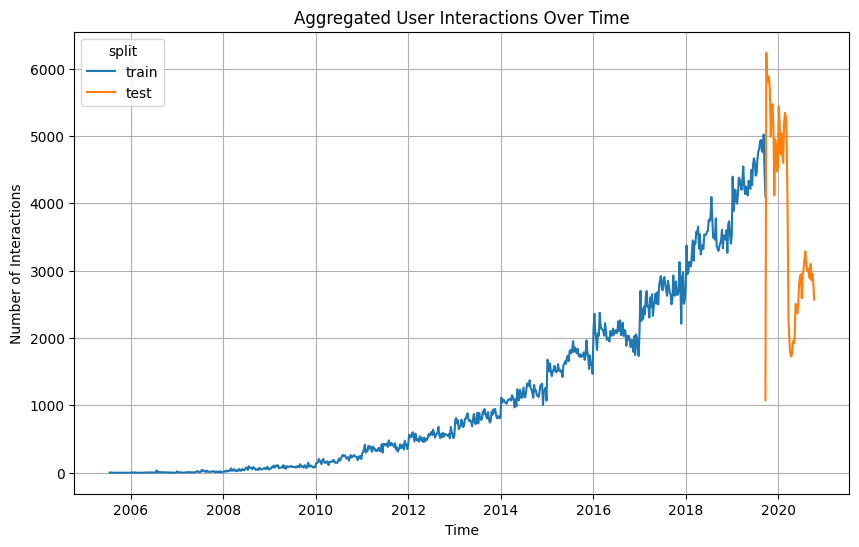

In [25]:
def plot_aggregated_interactions(train, test, time_unit='W'):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ns')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ns')

    train_agg = train.resample(time_unit, on='timestamp').size().reset_index(name='count')
    test_agg = test.resample(time_unit, on='timestamp').size().reset_index(name='count')

    train_agg['split'] = 'train'
    test_agg['split'] = 'test'

    combined_agg = pd.concat([train_agg, test_agg])

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=combined_agg, x='timestamp', y='count', hue='split')
    plt.title('Aggregated User Interactions Over Time')
    plt.xlabel('Time')
    plt.ylabel('Number of Interactions')
    plt.grid(True)
    plt.show()

val = splits['validation'][splits['validation'].user_id.isin(splits['validation_gt'].user_id.unique())]
val_gt = splits['validation_gt']
plot_aggregated_interactions(val, val_gt)

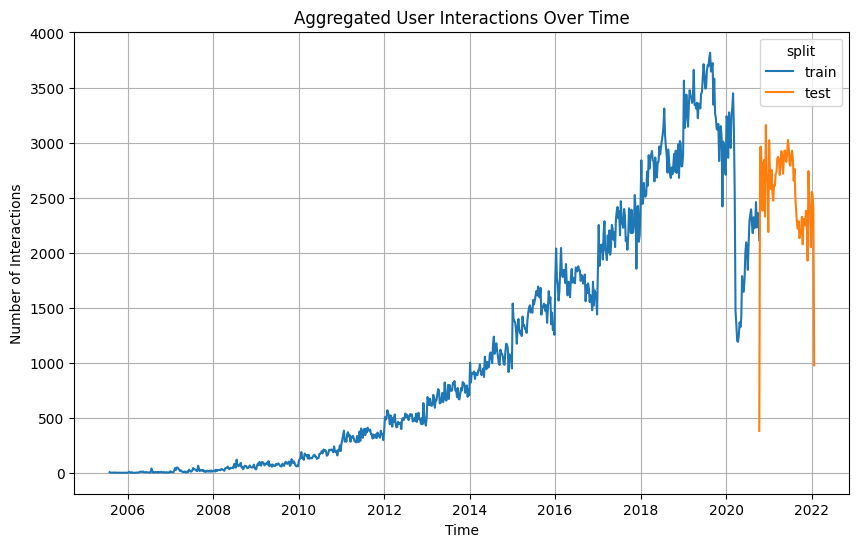

In [26]:
test = splits['test'][splits['test'].user_id.isin(splits['test_gt'].user_id.unique())]
test_gt = splits['test_gt']
plot_aggregated_interactions(test, test_gt)

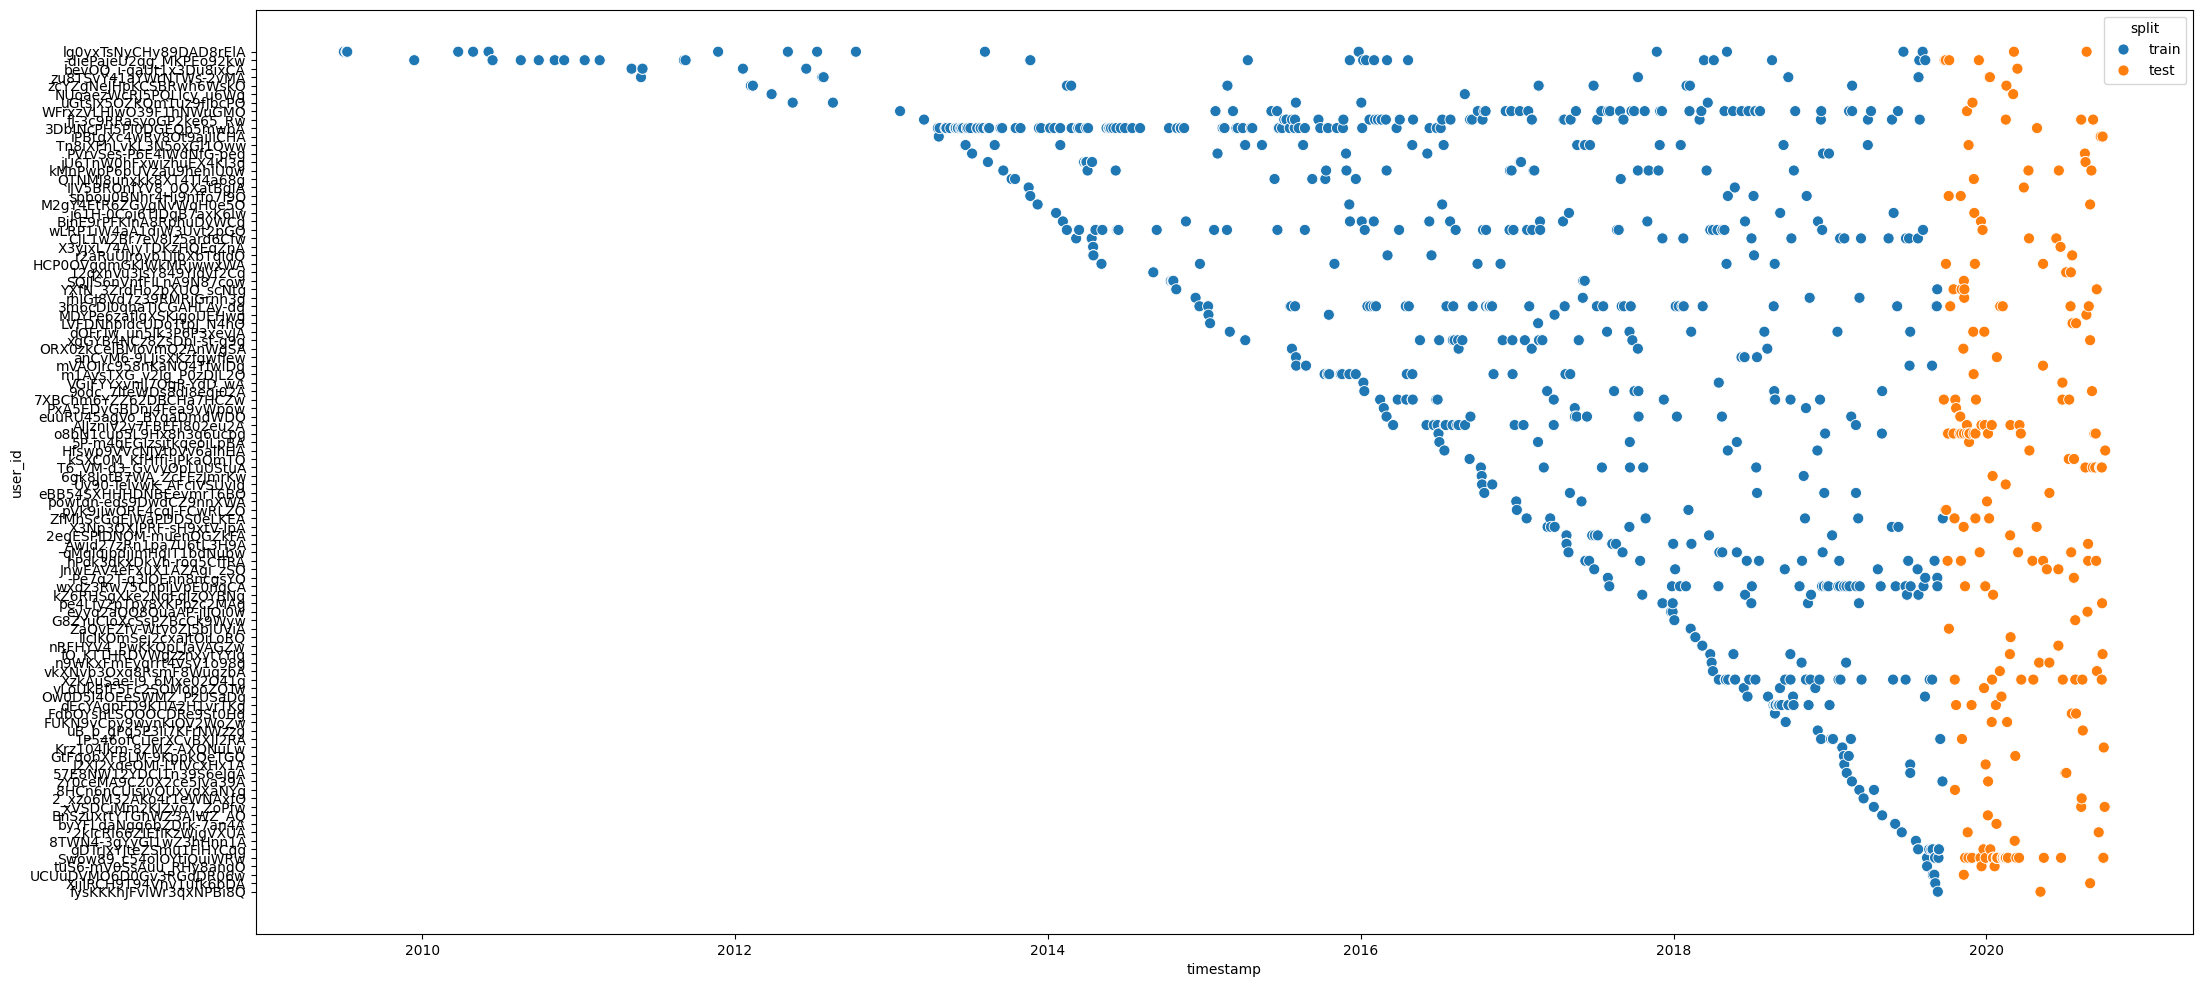

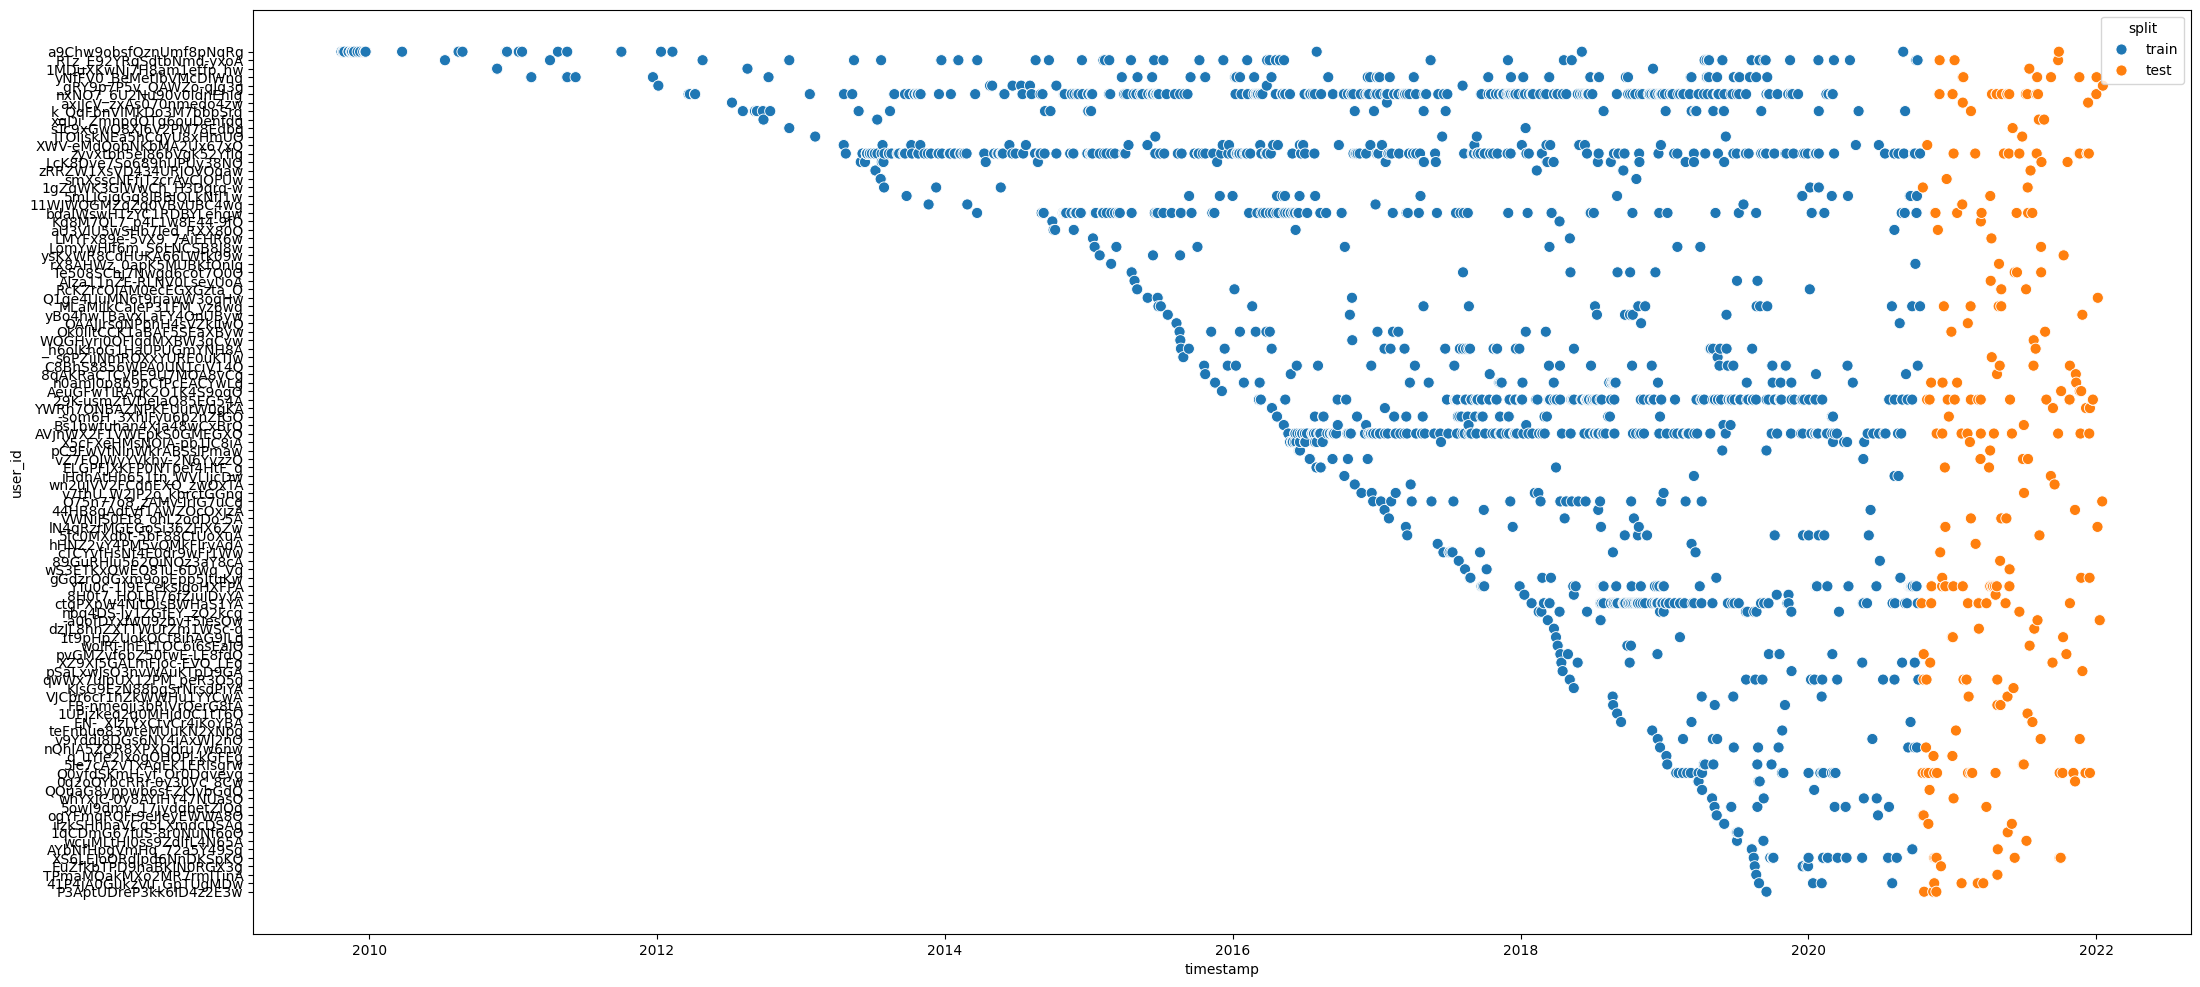

In [27]:
def show_train_test_sampled(train, test, sample_size=100):
    train = train.copy()
    test = test.copy()
    train['timestamp'] = pd.to_datetime(train['timestamp'], unit='ns')
    test['timestamp'] = pd.to_datetime(test['timestamp'], unit='ns')
    train['split'] = 'train'
    test['split'] = 'test'
    combined = pd.concat([train, test])
    sampled_user_ids = np.random.choice(combined['user_id'].unique(), size=sample_size, replace=False)

    sampled_data = combined[combined['user_id'].isin(sampled_user_ids)]
    plt.figure(figsize=(25, 12))
    sns.scatterplot(data=sampled_data, x='timestamp', y='user_id', hue='split', s=64)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()


show_train_test_sampled(val, val_gt)
show_train_test_sampled(test, test_gt)

In [28]:
splits['train'][splits['train'].user_id.isin(test_gt.user_id)]

,user_id,item_id,rating,timestamp
5523056,kQX4IZc95PkbkMcS9UbYOQ,dGeXdSMah56gEHwZNaRQKA,4.0,1122296524000000000
1152678,kQX4IZc95PkbkMcS9UbYOQ,9xErhLpjFcoA39AFeN3lUA,4.0,1122305337000000000
1444539,kQX4IZc95PkbkMcS9UbYOQ,ZMx3hds9eH24geGkuOQN0A,5.0,1122332614000000000
3346825,kQX4IZc95PkbkMcS9UbYOQ,XnQ84ylyAZwh-XfHGGNBbQ,4.0,1122384482000000000
4803329,kQX4IZc95PkbkMcS9UbYOQ,G4kmb7lGpbER5Jd2Al2TLw,5.0,1122820243000000000
...,...,...,...,...
1364191,R9IJ1Byr27n6wXj3QvJ2Lg,WSkzgp8MReuajWyHJqx2_g,4.0,1569114306000000000
3383977,noZUCQv3skMXM-VTfajkfA,59QYxl_ujYMMAn_aXkk3tg,5.0,1569114830000000000
6726798,1qqzR7isdip4ua6jlyQAVw,rYfMeGbDkYAe6bmSBHQB9w,5.0,1569114875000000000
6744110,_ipHJ9-yvbvphBDpxCzNeA,IzshPfwjbTkcwA87_GYCIw,4.0,1569114876000000000


In [29]:
len(set(splits['train'].item_id))

107404

In [30]:
len(set(val_gt.item_id))

50842

In [31]:
len(set(test_gt.item_id)) 

44794

In [32]:
len(set(test_gt.item_id) - set(val_gt.item_id))

12587

In [33]:
splits['train'][splits['train'].item_id.isin(set(test_gt.item_id) - set(val_gt.item_id))]

,user_id,item_id,rating,timestamp
3914401,nkN_do3fJ9xekchVC-v68A,BQGaox52fHg46Vzto_9Z_Q,4.0,1112232828000000000
6291218,iUeZhkI0OK0BisakOkb3pQ,iIyIVlK4ZeIIp9RayXRrNw,4.0,1116375175000000000
363145,58yhbFfNHjULDZx0FD-Dvw,gnEyjxoBYQcP9Bz72C95YA,4.0,1118211137000000000
1422809,LZkEU9n-0XDagWrPkPzIwA,lh3ApskP-4XVdsQ-82792g,5.0,1119986880000000000
5598228,n-lBS02-3yvlY5Q91mmwDA,68AYY0l4jZMAr3lOGHuLvA,4.0,1121017428000000000
...,...,...,...,...
5478191,HB52HJAcW7zCcLRw2Oq8tw,U5eOz4szkvgP5eZQnKHjsQ,4.0,1569110259000000000
6241502,SPQT8wC1gFX3a-EkXkhgdQ,OZKYA7JgLHq7PtRW4ArIOA,5.0,1569110424000000000
4083064,2ykIQqJHW18oxqdK6_ACpA,VlqkS4IWZh9b53W5IXzsMA,5.0,1569112495000000000
3376579,0O6wRfapJ7GQJkDNHGZtTw,7pUoa0urRRWw5MM28YwyZw,5.0,1569114020000000000


In [34]:
len(set(val_gt.item_id) - set(test_gt.item_id))

18635

In [35]:
splits['train'][splits['train'].item_id.isin(set(val_gt.item_id) - set(test_gt.item_id))]

,user_id,item_id,rating,timestamp
4179799,3zBJUlWtPNoZ0uN83ODbyg,2bXm0SynOfxDzfrdrCyXqg,4.0,1108524202000000000
6942,XCsZ3hWa_6oP1WkWvK7pmg,29YqJwOGEuAWqlHZxMc1OA,5.0,1109699235000000000
1417761,58yhbFfNHjULDZx0FD-Dvw,rgT1MuKGJHgdNqdm1zxJHw,5.0,1110338773000000000
6291264,vetI1F4btXdQAe5G2A2ciA,i-n7LKMjQsH94wfW8FNMBg,5.0,1111110572000000000
1434211,y8lz_6KWGOQ9jcTyIdwTLQ,yy6suHtRjIg3RwsNt5vstA,5.0,1111365541000000000
...,...,...,...,...
6810108,qSnXkWHdZXr8Jj8StbsFBw,c6RWw740cIB9-efs9tSLyg,5.0,1569112454000000000
6038978,DQ6jWIWjzVRbS_5QA-FMUg,ApkC8jh0iBkYWy5paByE5w,4.0,1569112700000000000
3487649,VyU5wZeQeijq1HRbu5UEXw,tMZysJlRjlbMy9qWZuuPLA,5.0,1569112960000000000
4174262,olXEpml_LfisIvolB6TRYw,3tMMCXrwxxkd-DNsCPekJw,5.0,1569113219000000000


In [36]:
test_gt

,user_id,item_id,rating,timestamp
2728476,NBhBECdmKXspNMQXrowLxg,OOG4Q1whPMP0-U_UJv_HdA,5.0,1602390131000000000
6219460,vQSNPmFOXeZCVHMpUGgAdQ,XZT06uHRXS-E6t3OOodShw,5.0,1602390445000000000
6141785,8Gtpx5xkgVdGjHL5S3u5uQ,KiwskluQ7tMqZqvuf872vg,4.0,1602390479000000000
4804487,UBiJ0YhkHZWM1CuUTy-2qA,i_FWONQD1ZBqrNE2b-M5Ug,5.0,1602391395000000000
6149973,gGW-gPyI8wWkiz9Z7sr3tA,LzVvcVm48zYIcQnwLKt1oA,5.0,1602391459000000000
...,...,...,...,...
4140565,sX61XBi6Tf5K01vsAIiN0w,9vH3pJlBjfhi8HFlX9EB1w,5.0,1642621104000000000
1414389,jCFYwSOZOUs1-3Nxab3GdQ,iYUwyARgC_RNPA1rTlL3-Q,5.0,1642621342000000000
6280847,BlvDcYBfjf55OuCLfixEsQ,Eo0psaCr_gcty9QqyUy46Q,5.0,1642621443000000000
4878781,lmiiFd9KC15fs4xtEoXRvw,XDMno4l95AXgYOd0yDtHZA,5.0,1642621693000000000


In [37]:
test_gt[test_gt.item_id.isin(val_gt.item_id.unique())]

,user_id,item_id,rating,timestamp
2728476,NBhBECdmKXspNMQXrowLxg,OOG4Q1whPMP0-U_UJv_HdA,5.0,1602390131000000000
6219460,vQSNPmFOXeZCVHMpUGgAdQ,XZT06uHRXS-E6t3OOodShw,5.0,1602390445000000000
6141785,8Gtpx5xkgVdGjHL5S3u5uQ,KiwskluQ7tMqZqvuf872vg,4.0,1602390479000000000
4804487,UBiJ0YhkHZWM1CuUTy-2qA,i_FWONQD1ZBqrNE2b-M5Ug,5.0,1602391395000000000
6149973,gGW-gPyI8wWkiz9Z7sr3tA,LzVvcVm48zYIcQnwLKt1oA,5.0,1602391459000000000
...,...,...,...,...
4140565,sX61XBi6Tf5K01vsAIiN0w,9vH3pJlBjfhi8HFlX9EB1w,5.0,1642621104000000000
1414389,jCFYwSOZOUs1-3Nxab3GdQ,iYUwyARgC_RNPA1rTlL3-Q,5.0,1642621342000000000
6280847,BlvDcYBfjf55OuCLfixEsQ,Eo0psaCr_gcty9QqyUy46Q,5.0,1642621443000000000
4878781,lmiiFd9KC15fs4xtEoXRvw,XDMno4l95AXgYOd0yDtHZA,5.0,1642621693000000000
